# Amortized posterior inference on Gaussian example

Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/01_gaussian_amortized.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/01_gaussian_amortized.ipynb) in the `sbi` repository.

In this tutorial, we will demonstrate how `sbi` can infer an amortized posterior for a simple toy model with a uniform prior and Gaussian likelihood.

In [1]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference.base import infer

## Defining prior, simulator, and running inference
Say we have a 3-dimensional parameter space, and the prior is uniformly distributed between `-2` and `2` in each dimension, i.e. $\theta \in [-2,2], y\in [-2,2], z \in [-2,2]$.

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

Our simulator takes the input parameters, adds `1.0` in each dimension, and then adds some Gaussian noise:

In [3]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

We can then run inference (either with the simple interface or with the flexible interface):

In [4]:
posterior = infer(linear_gaussian, prior, "SNPE", num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 66 epochs.

## Amortized inference
Note that we have not yet provided an observation to the inference procedure. In fact, we can evaluate the posterior for different observations without having to re-run inference. This is called amortization. An amortized posterior is one that is not focused on any particular observation. Naturally, if the diversity of observations is large, any of the inference methods will need to run a sufficient number of simulations for the resulting posterior to perform well across these diverse observations.

Let's say we have two observations `x_o_1 = [0,0,0]` and `x_o_2 = [2,2,2]`:

In [5]:
x_o_1 = torch.zeros(3,)
x_o_2 = 2.0 * torch.ones(3,)

We can draw samples from the posterior given `x_o_1` and then plot them:

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

(10000,)
(10000,)
(10000,)


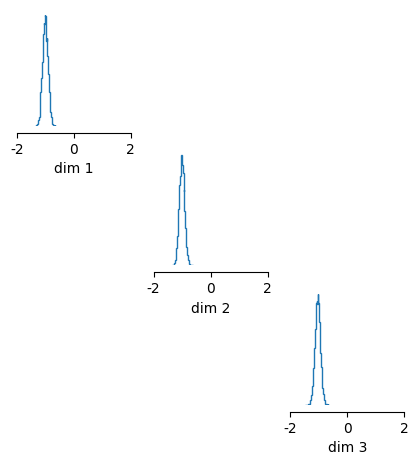

In [6]:
posterior_samples_1 = posterior.sample((10000,), x=x_o_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

As it can be seen, the posterior samples are centered around `[-1,-1,-1]` in each dimension. 
This makes sense because the simulator always adds `1.0` in each dimension and we have observed `x_o_1 = [0,0,0]`.

Since the learned posterior is amortized, we can also draw samples from the posterior given the second observation without having to re-run inference:

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

(10000,)
(10000,)
(10000,)


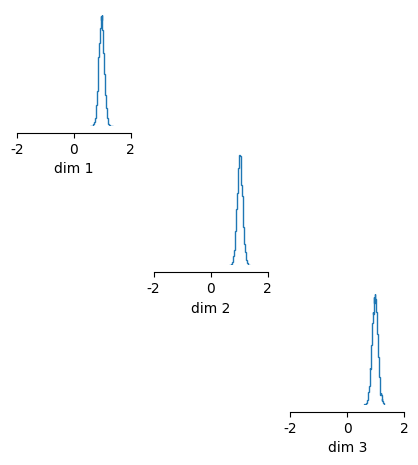

In [7]:
posterior_samples_2 = posterior.sample((10000,), x=x_o_2)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_2, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

So, if we observed `x_o_2 = [2,2,2]`, the posterior is centered around `[1,1,1]` -- again, this makes sense because the simulator adds `1.0` in each dimension.